# Сборный проект. Исследование закономерностей, определяющих успешность игры.

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года. В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных

In [1]:
import pandas as pd # импортирую библиотеки, которые понадобятся для выполнения проекта
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats as st
import seaborn as sns


In [2]:
df=pd.read_csv('/datasets/games.csv')
display(df) # .head() не использую, чтобы увидеть и последние строки датасета
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Полученные данные требуют предобработки:**

1. название столбцов необходимо привести к нижнему регистру;
2. обработать пропущенные значения:
- в столбце "name" всего 2 пропуска, можно попробовать вручную отыскать пропущенные названия по имеющимся данным (год выпуска, продажи, рейтинги)
- в "year_of_release" 269 пропущенных значений, отыскивать их вручную слишком долго, качественно заменить их по другому мы не сможем (категориальная переменная), поэтому оставим этот столбец как есть, тем более количество пропусков относительно всего датасета незначительно.
- а вот в столбцах "сritic_score", "user_score", "rating" очень много пропущенных значений, возможно это связано с тем, что раньше не собирались данные об оценках от игроков и критиков, рейтингах и т.д., поэтому таких данных в таблице нет, заменить их средним/медианным нельзя, поскольку это значительно исказит общую картину при анализе (очень много пропусков), поэтому в столбцах "сritic_score" и "user_score" следует заменить NaN-ы на невозможное для этих столбцов значение (999 например), таким образом при работе с данными можно будет отсортировать пропущенные значения, отделив их от реальных данных, а в столбце "rating" заменить пропуски значением "unknown";
3. изменить типы данных следующих столбцов:
- "year_of_release" - int64 (обозначение года не требует значков после запятой),
- "сritic_score" - int64 (оценка критиков имеет целочисленное значение),
- "user_score" - float64 (оценка пользователей не может иметь тип "object");
4. в столбце "rating" имеется неявный дубликат: значение К-А - это устаревшее обозначение рейтинга Е, К-А необходимо заменить на Е
5. проверить на наличие дубликатов и избавиться от них при наличии

## Предобработка данных

 1. Меняем названия столбцов, сменив регистр на нижний:

In [3]:
df.columns = df.columns.str.lower()

2. Обработаем пропуски в столбцах, отмеченных выше:
- "name"

In [4]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В первом случае имеем в распоряжении данные о годе выпуска, платформе и о продажах, по ним определить название игры не получилось (либо я плохо умею гуглить), во втором случае данных еще меньше. Поскольку определить названия игр нет возможности и, судя по данным о продажах, это не самые популярные игры, можно удалить эти строки из датасета, влияния на общую картину анализа от удаления не будет. Строк, с пропущенным годом релиза, незначительное количество, их тоже можно удалить.

In [1]:
df = df.dropna(subset=['name']).reset_index(drop=True)
df = df.dropna(subset=['year_of_release']).reset_index(drop=True)

NameError: name 'df' is not defined

-  "сritic_score", "user_score" и "rating"

Как отмечалось выше, поскольку в этих столбцах удалить или качественно заменить пропуски нельзя, для дальнейшей работы пропущенные значения следует заполнить нерациональными данными (999). Но прежде обратимся к столбцу "user_score", поскольку его тип данных "object", что странно для числовых данных:

In [7]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Данный столбец имеет среди значений аббревиатуру 'tbd', что означает "To Be Determined" - в переводе " Предстоит определить", т.е. рейтинг не определен, возможно из-за малого количества либо вовсе отсутствия оценок от пользователей. Фактически 'tbd' является пропущенным значением в нашей таблице, т.е. NaN-ом, поэтому его также заменим на 999. 

In [8]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN)
for column in ['critic_score', 'user_score']:
    df[column] = df[column].fillna(999)

In [9]:
df['rating'] = df['rating'].fillna('unknown')

3. Изменим типы данных в столбцах "year_of_release", "сritic_score" и  "user_score"

In [10]:
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['critic_score'] = df['critic_score'].astype('Int64')
df['user_score'] = df['user_score'].astype('float64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null Int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       16444 non-null Int64
user_score         16444 non-null float64
rating             16444 non-null object
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


4. Заменим значения К-А на Е в столбце "rating"

In [11]:
df['rating'] = df['rating'].replace('K-A', 'E')
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

5. Проверим на наличие дубликатов

In [12]:
'Количество дубликатов:', df.duplicated().sum()

('Количество дубликатов:', 0)

6. Подсчитаем суммарные продажи и запишем результат в отдельный столбец "total_sales"

In [13]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,999,999.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,999,999.0,unknown,31.38


Выявленные недостатки в данных устранены, датасет готов для дальнейшего анализа.

## Исследовательский анализ данных

1. •	Сколько игр выпускалось в разные годы? Важны ли данные за все периоды?

Сгруппируем количество игр по году выпуска и построим гистограмму:

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

Text(0, 0.5, 'Количество выпущенных игр')

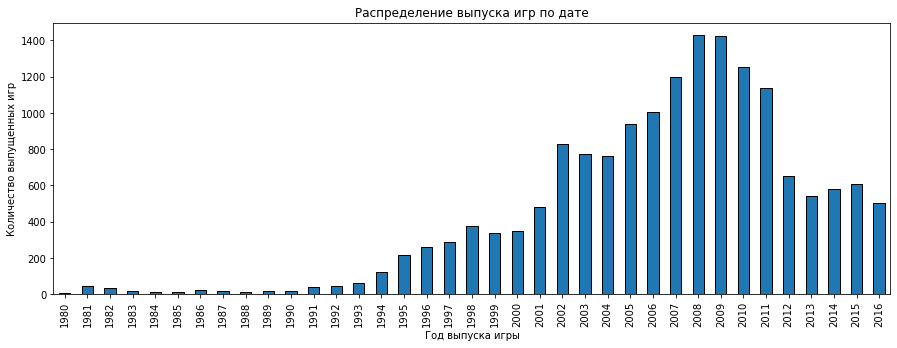

In [14]:
games_by_years=df.groupby('year_of_release')['name'].count() #группирую данные по году выпуска
display(games_by_years)
games_by_years.plot(kind='bar', y='name', figsize=(15,5), ec='black') # строим диаграмму распределения игр по году выпуска
plt.title('Распределение выпуска игр по дате')
plt.xlabel('Год выпуска игры')
plt.ylabel('Количество выпущенных игр')

Судя по полученным данным и графику можно сказать, что в 80-е годы спрос на игры был незначительным. С начала 90-ых начался рост выпуска новых видеоигр, связано это скорее всего с их развитием (3D графика, новые жанры, новые возможности игры), а также доступностью для масс ПК и игровых консолей. С развитием видеоигр в 2000-ых наблюдается резкий рост, пик приходится на 2008-2009 годы. После чего популярность игр, а собственно и выпуск новых, начинает снижаться. Связано такое падение скорее всего с развитием мобильных устройств и игр на них. Начиная с 2012 года и до конца исследуемого периода выпуск новых видеоигр остается примерно на одном уровне, около 500 в год. Подводя итог можно ответить и на второй вопрос: "Важны ли данные за все периоды?". Ответ - да, важны.

2.  •	Как менялись продажи по платформам? 

Здесь также сгруппируем данные и построим гистограмму:

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
PSV       53.81
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: total_sales, dtype: float64

Text(0, 0.5, 'Количество проданных игр, млн.')

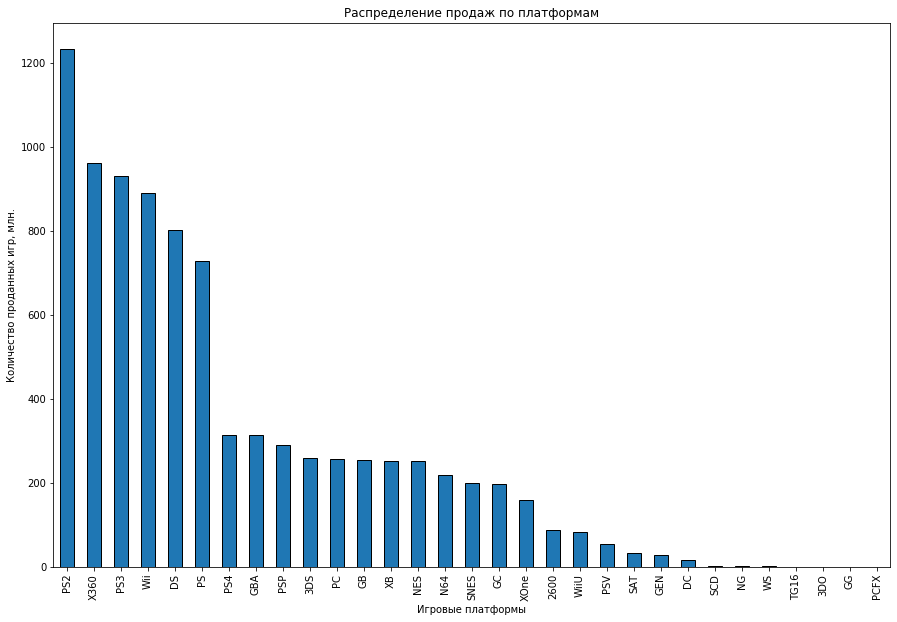

In [15]:
sales_by_platform=df.groupby('platform')['total_sales'].sum().sort_values(ascending=False) # группируем данные, отсортировав их по убыванию количества продаж
display(sales_by_platform)
sales_by_platform.plot(kind='bar', y='total_sales', figsize=(15,10), ec='black') # строим диаграмму 
plt.title('Распределение продаж по платформам')
plt.xlabel('Игровые платформы')
plt.ylabel('Количество проданных игр, млн.')

Безоговорочным лидером по количеству проданных игр является PlayStation 2, можно сказать легендарная консоль) Среди успешных консолей еще стоит отметить Xbox360, PlayStation 3, Nintendo Wii и DS, а также первая PlayStation. Показатели продаж видеоигр для других приставок значительно ниже лидеров.

- Выберем платформы с наибольшими суммарными продажами (топ 6) и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Text(0.5, 0, 'Год выпуска игры')

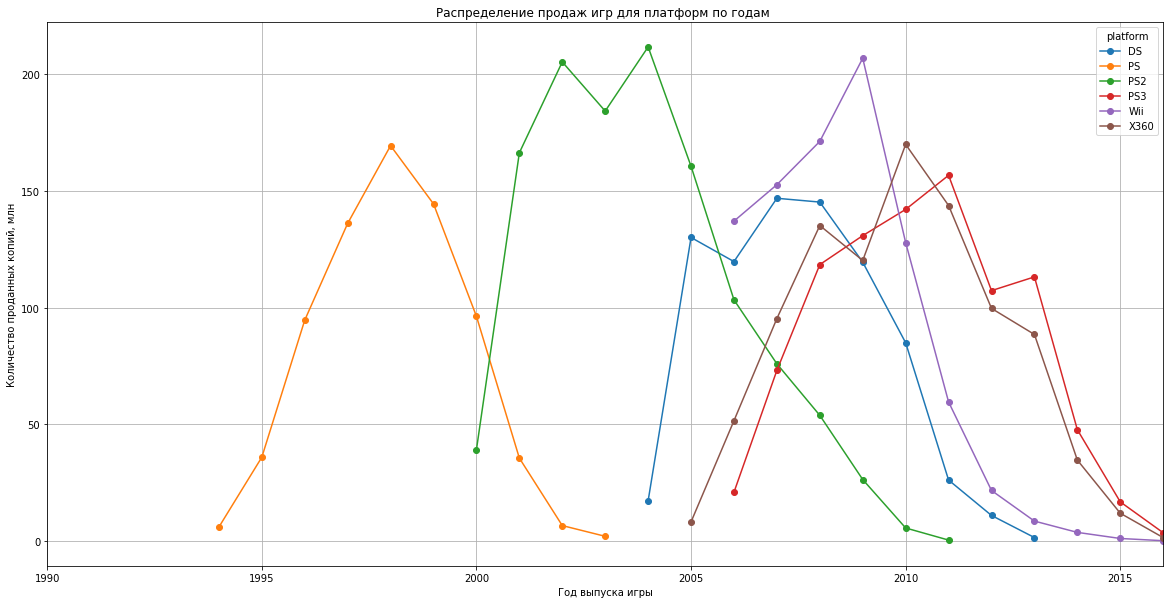

In [16]:
platform_top_6 = sales_by_platform.head(6).index.to_list()   # формируем список из топ 6 платформ 
# создаем сводную таблицу по срезу данных
platform_top_6_pivot = df.query('platform == @platform_top_6').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')  
platform_top_6_pivot.plot(grid=True, figsize=(20, 10), style ='o-') # строим графики
plt.xlim(1990, 2016)
plt.title('Распределение продаж игр для платформ по годам ')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Год выпуска игры')                                               

По полученному графику можно примерно определить срок использования консолей:
- PS около 10 лет, 1994-2003 гг.
- PS2 около 11 лет, 2000-2011 гг.
- PS3 около 10 лет, 2006-2016 гг. (пока еще используется, но с выходом PS4 спрос резко снизился в 2013 году)
- DS около 9 лет, 2004-2013 гг.
- Wii около 10 лет, 2006-2016 гг. (пока еще используется, но пик популярности далеко позади)
- X360 около 11 лет 2005-2016 гг. (тоже еще используется, но сравнительно мало)

Таким образом можно отметить, что средний срок службы игровых консолей около 10 лет, потом к ним на смену приходят обновленные модели, что резко сокращает спрос на уже используемые.


3. Определение актуального периода на 2017 год

Поскольку данные за 2016 год неполные, за актуальный период на 2017 год примем 3 последних года с полным объемом данных, т.е. период с 2013 года включительно, тем более, что в этом же году состоялся выпуск новых версий популярных консолей

Text(0.5, 0, 'Год выпуска игры')

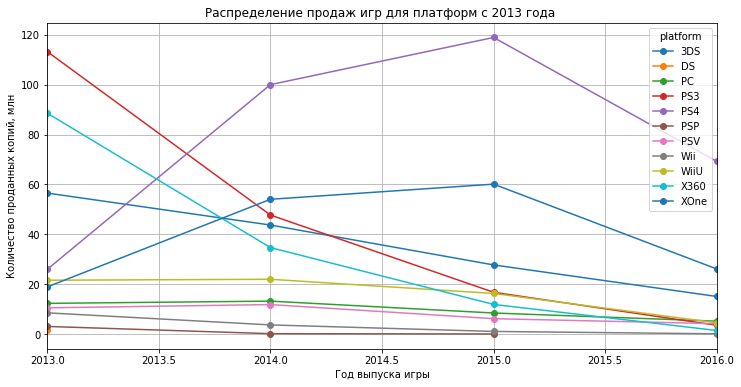

In [17]:
df_after_2013 = df[df['year_of_release']>=2013] # определяем актуальный период
# создаем сводную таблицу за выбранный период 
df_after_2013_pivot = df_after_2013.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')
df_after_2013_pivot.plot(grid=True, figsize=(12, 6), style ='o-') # строим графики
plt.xlim(2013, 2016)
plt.title('Распределение продаж игр для платформ с 2013 года ')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Год выпуска игры')  

Судя по данным за актуальный период явным лидером среди платформ можно назвать PlayStation 4, определенной популярностью пользуются также Xbox One и Nintendo 3DS. Поэтому для определения потенциально прибыльных платформ на 2017 год можно смело делать выбор в пользу этих трёх консолей.

4. •	График «ящик с усами» по глобальным продажам игр в разбивке по платформам

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


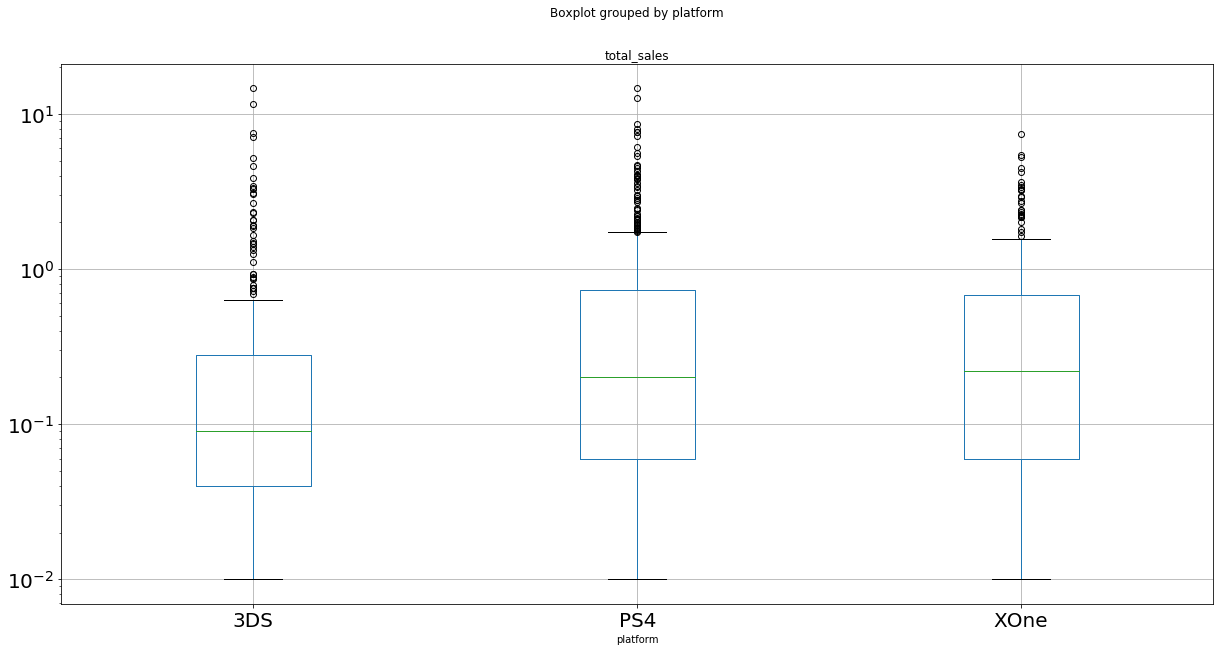

In [18]:
promising_platforms = ['PS4', 'XOne', '3DS']
df_plot_global_platform = df_after_2013.query("platform in @promising_platforms").boxplot(column='total_sales', 
                                                                                          by="platform in @promising_platforms".split()[0], 
                                                                                          fontsize=20, figsize=(20,10)).semilogy()

Показатели PS4 и XOne примерно схожи - среднее значение около 0,65-0,7 млн. копий, медианное - 0,2-0,3 млн., причем медиана не стремится к верхней границе нормального размаха. 
А что касается 3DS, то здесь положение еще хуже. Среднее значение - 0,4 млн, медианное - 0,15 млн., нормальный размах значительно меньше, чем у PS4 и XOne, при этом большое количество выбросов.



5. Влияние отзывов пользователей и критиков на продажи

Для анализа возьмем самую популярную по количеству продаж платформу - PlayStation 2. Посчитаем корреляцию между отзывами и продажами и построим диаграмму рассеяния.

In [19]:
# отфильтруем данные, выбрав данные по PS2 и не включая пропуски, которые мы заполнили невозможными значениями
platform_ps2 = df[(df['platform'] == 'PS2') & (df['user_score'] < 900) & (df['critic_score'] < 900)] 
platform_ps2_loc = platform_ps2.loc[:, ['total_sales', 'user_score', 'critic_score']]
platform_ps2_loc.corr()

,total_sales,user_score,critic_score
total_sales,1.000000,0.171690,0.386415
user_score,0.171690,1.000000,0.565841
critic_score,0.386415,0.565841,1.000000


Text(0.5, 1, 'Влияние отзывов пользователей и критиков на продажy PS2')

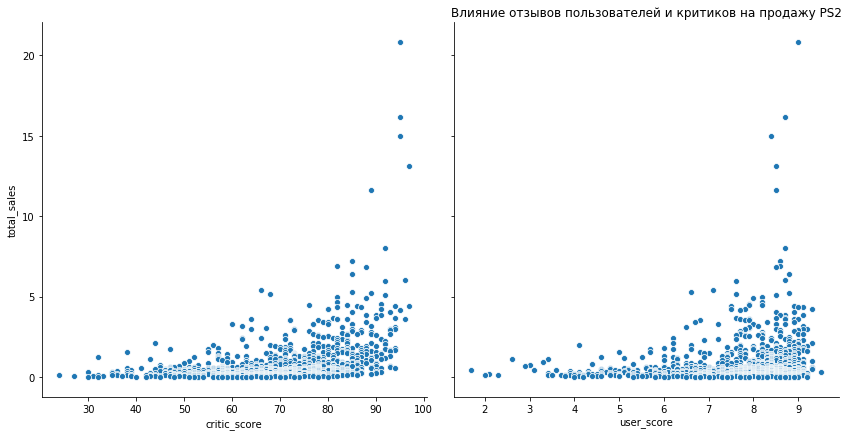

In [20]:
sns.pairplot(platform_ps2_loc, height=6, x_vars=['critic_score', 'user_score'], y_vars='total_sales') # строим матрицу корреляции
plt.title('Влияние отзывов пользователей и критиков на продажy PS2')

По полученным результатам можно сделать вывод: зависимость между отзывами от пользователей и критиков однозначно есть, причем прямо пропорциональная - с увеличиением оценок, растут и продажи. По значениям корреляции видно, что в большей степени продажи зависят от оценок критиков, в меньшей степени - от оценок пользователей. Полученные диаграммы наглядно подтверждают описанный выше вывод.

6. Соотношение результата с продажами игр для других платформ

Для наглядности такого соотношения, используем тепловые карты, визуализируя результат корреляции для отобранных нами платформ (PS3, XOne, 3DS) и самой популярной платформы PS2.

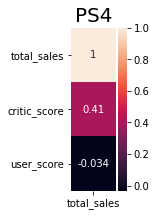

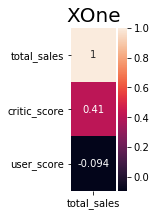

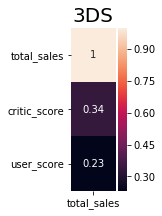

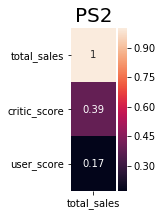

In [21]:
promising_platforms_and_ps2 = promising_platforms.append('PS2') # добавим к отобранным ранее платформам PS2
for platform in promising_platforms:  # строим тепловую карту по каждой платформе
  platform_curr = df[(df['platform'] == platform) & (df['user_score'] < 900) & (df['critic_score'] < 900)].loc[:, ['total_sales', 'user_score', 'critic_score']]
  plt.figure(figsize=(1,3))
  sns.heatmap(platform_curr.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), annot=True).set_title(platform, fontsize=20)
  plt.show()

Судя по полученным результатам можно сказать, что зависимость продаж от оценок критиков находится примерно в одном диапазоне 0,34 - 0,41. Т.е. оценки критиков влияют на продажи игр для платформ, пользователи ориентируются на оценки критиков при покупке игр. А вот оценки пользователей на продажи игр влияют по разному, для PS2 и 3DS зависимость прямо пропорциональная, хоть и значительно ниже, чем от оценок критиков. А вот для консолей PS4 и XOne зависимость продаж от оценок пользователей обратная, скорее всего при покупке пользователи не принимают во внимание рейтинг игр среди пользователей, а совершают покупку ориентируясь на маркетинговые программы новых игр.

7. Распределение игр по жанрам. Какие жанры самые прибыльные? Выделяются ли жанры с высокими и низкими продажами?

Для ответа на поставленные вопросы, сгруппируем данные по жанру, подсчитаем количество, общие суммы продаж и *медианные значения продаж* по жанрам игр, построим диаграмму для наглядности полученных результатов

In [22]:
genre_pivot = df_after_2013.groupby('genre').agg({'total_sales': ['count', 'sum', 'median']}) # группируем данные по жанру
genre_pivot.columns = ['count', 'sum', 'median'] # переименуем столбцы для удобства
genre_pivot.sort_values(by='count', ascending=False)

,count,sum,median
genre,,,
Action,766,321.87,0.110
Role-Playing,292,145.89,0.125
Adventure,245,23.64,0.030
Sports,214,150.65,0.240
Shooter,187,232.98,0.450
Misc,155,62.82,0.100
Racing,85,39.89,0.120
Fighting,80,35.31,0.125
Platform,74,42.63,0.225


Text(0.5, 0, 'Жанры игр')

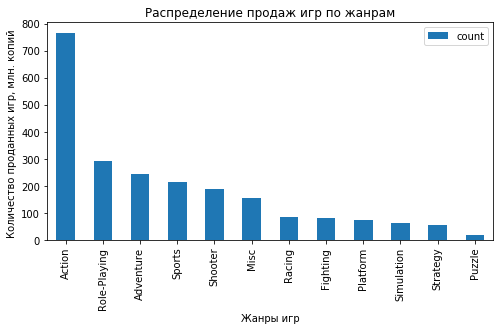

In [23]:
genre_pivot.sort_values(by='count', ascending=False).plot(kind='bar', y='count', figsize=(8,4))   # строим диаграмму                   
plt.title('Распределение продаж игр по жанрам')
plt.ylabel('Количество проданных игр, млн. копий ')
plt.xlabel('Жанры игр')


Text(0.5, 0, 'Жанры игр')

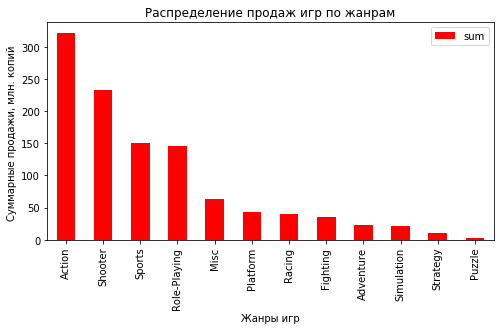

In [24]:
genre_pivot.sort_values(by='sum', ascending=False).plot(kind='bar', y='sum', figsize=(8,4), color = 'red')   # строим диаграмму                   
plt.title('Распределение продаж игр по жанрам')
plt.ylabel('Суммарные продажи, млн. копий ')
plt.xlabel('Жанры игр')


Text(0.5, 0, 'Жанры игр')

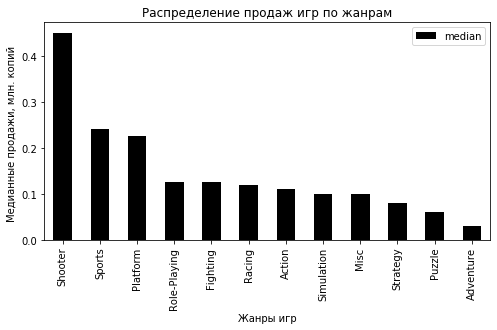

In [25]:
genre_pivot.sort_values(by='median', ascending=False).plot(kind='bar', y='median', figsize=(8,4), color = 'black')   # строим диаграмму                   
plt.title('Распределение продаж игр по жанрам')
plt.ylabel('Медианные продажи, млн. копий ')
plt.xlabel('Жанры игр')

По полученным данным можно сделать следующий вывод:

- самым популярным жанром игр по количеству продаж с отрывом является "Экшн", популярностью пользуются также игры жанров "РПГ", "Приключения", "Спорт", "Шутер", наименее популярными жанрами играм можно считать "Симуляторы", "Стратегии" и "Головоломки"
- по суммарным продажам в лидерах также жанр "Экшн" ввиду большой популярности, среди лидеров стоит отметить жанры "Шутер", "Спорт" и "РПГ", в аутсайдерах все также "Симуляторы", "Стратегии" и "Головоломки"
- но если обратиться к данным по медианным продажам, то здесь уже жанр "Экшн" далеко не самый прибыльный, лидером по показателю медианных продаж является жанр "Шутер", чуть менее - "Спорт" и "Платформер", а вот жанр "Приключения" по этому показателю оказался самым слабым

Подводя итог, самыми прибыльными жанрами игр стоит считать "Шутер", "Спорт" и "Экшн" (из-за высокой популярности), наименее прибыльными - "Стратегии" и "Головоломки".

## Портрет пользователя каждого региона

1. Самые популярные платформы в каждом регионе (NA, EU, JP)

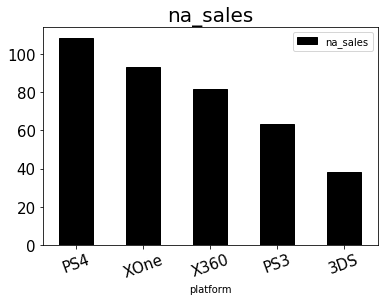

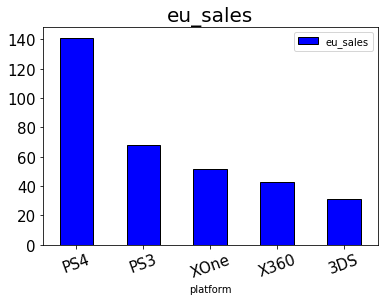

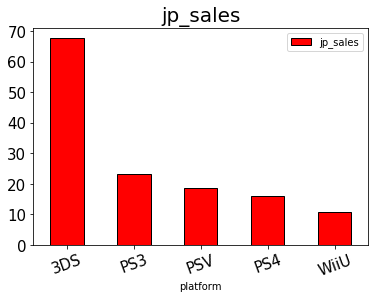

In [26]:
region_sales = ['na_sales', 'eu_sales', 'jp_sales'] # список исследуемых регионов
for region in region_sales:           # для каждого региона строим диаграмму самых популярных платформ
    pivot_region =  df_after_2013.groupby('platform').agg({region: 'sum'}).sort_values(by=region, ascending=False)[:5]
    color_dict = {'na_sales': 'black', 'eu_sales': 'blue', 'jp_sales': 'red'}
    pivot_region.plot(kind='bar', ec='black', color=color_dict[region], title=region, fontsize=15, rot=20).title.set_size(20)

Популярность платформ на рынках Северной Америки и Европы схожи, в Северной Америке популярность PS и Xboxe относительно равная, тогда как в Европе предпочтительнее консоли от Sony. В Японии же с огромным отрывом лидирует Nintendo 3DS, большой популярностью пользуются портативные консоли, а приставки от Xbox даже не входят в топ 5 по предпочтениям.

2. Самые популярные жанры в каждом регионе (NA, EU, JP)

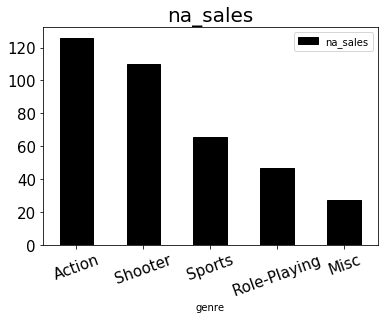

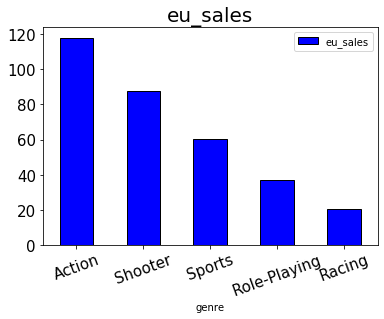

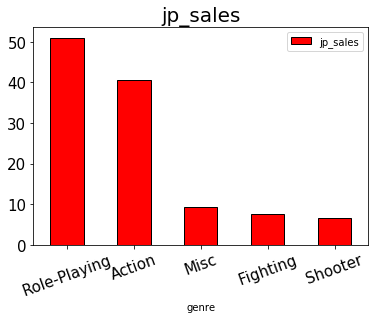

In [27]:
for region in region_sales: # строим диаграммы самых популярных жанров по регионам
    pivot_region =  df_after_2013.groupby('genre').agg({region: 'sum'}).sort_values(by=region, ascending=False)[:5]
    color_dict = {'na_sales': 'black', 'eu_sales': 'blue', 'jp_sales': 'red'}
    pivot_region.plot(kind='bar', ec='black', color=color_dict[region], title=region, fontsize=15, rot=20).title.set_size(20)

В Северной Америке и Европе предпочтения по жанрам примено схожи - "Экшн", "Спорт" и "Шутер" пользуются здесь наибольшей популярностью. 

А вот в Японии с большим отрывом лидируют жанры "РПГ" и "Экшн", другие жанры пользуются значительно меньшей популярностью. 

3. Влияние рейтинга ESRB на продажи в отдельном регионе.

In [28]:
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'EC', 'RP'], dtype=object)

Для наглядности и понимания создадим новый столбец в исходном датафрейме с расшифровкой указателя ESRB рейтинга по возрасту
(расшифровка рейтинга ESRB из Википедии):


In [29]:
esrb = {'E': '6+', 'M': ' 17+', 'T': '13+', 'E10+': '10+', 'AO': '18+', 'EC': '3+', 'RP': 'рейтинг ожидается', 'unknown': 'unknown'}
df['esrb'] = df['rating'].map(esrb)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,esrb
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54,6+
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,999,999.0,unknown,40.24,unknown
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52,6+
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77,6+
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,999,999.0,unknown,31.38,unknown


Теперь построим графики по каждому региону:

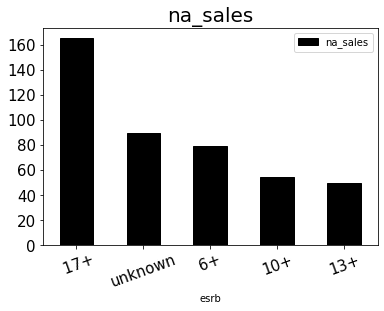

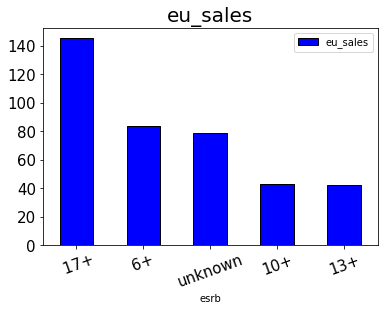

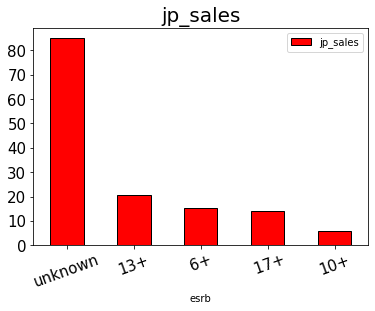

In [30]:
df_after_2013 = df[df['year_of_release']>=2013]
for region in region_sales:
    pivot_region =  df_after_2013.groupby('esrb').agg({region: 'sum'}).sort_values(by=region, ascending=False)[:5]
    color_dict = {'na_sales': 'black', 'eu_sales': 'blue', 'jp_sales': 'red'}
    pivot_region.plot(kind='bar', ec='black', color=color_dict[region], title=region, fontsize=15, rot=20).title.set_size(20)

По полученным данным делаем вывод:
- огромное количество пропущенных значений мешает качественно проанализировать спрос на игры в исследуемых регионах (особенно в Японии)
- в Северной Америке и Европе наибольшей популярностью пользуются игры с самым высоким возрастным ограничением 17+
- тогда как в Японии преобладают продажи игр без рейтинга. А если вспомнить, что ESRB предназначен для рецензирования игр США и Канады, то это все объясняет: на территории Японии действует собственная система рейтинга, и ESRB не является обязательным

## Проверка гипотез

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Поскольку в нулевой гипотезе должно присутствовать равенство, формулируем их таким образом:

- H0: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"
- Н1: "Средние пользовательские рейтинги платформ Xbox One и PC отличаются"

Пороговое значение alpha примем равное 0,05, для нашей выборки такое значение будет достаточным для подтверждения или опровержения гипотез

In [31]:
user_score_xone = df[(df['platform'] == 'XOne') & (df['user_score'] < 900)] # выбираем данные по XOne, не включая пропуски
user_score_pc = df[(df['platform'] == 'PC') & (df['user_score'] < 900)] # выбираем данные по PC, не включая пропуски

In [32]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(user_score_xone['user_score'], user_score_pc['user_score'])

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу, т.е. средние пользовательские рейтинги платформ Xbox One и PC различаются!")
else:
    display("Не получилось отвергнуть нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC одинаковы!")

'p-значение:'

1.3037979620149106e-05

'Отвергаем нулевую гипотезу, т.е. средние пользовательские рейтинги платформ Xbox One и PC различаются!'

P-значение в нашем эксперименте значительно меньше alpha, даже если принять alpha равную 0,01, значит можно смело отвергнуть нулевую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

Посмотрим насколько сильно различаются рейтинги:

In [33]:
display('{:} {: >5.2f} '.format("Средний пользовательский рейтинг платформ Xbox One:", user_score_xone['user_score'].mean() ))
display('{:} {: >11.2f} '.format("Средний пользовательский рейтинг платформ PC:", user_score_pc['user_score'].mean() ))

'Средний пользовательский рейтинг платформ Xbox One:  6.52 '

'Средний пользовательский рейтинг платформ PC:        7.07 '

Действительно, средние пользовательские рейтинги Xbox One и ПК отличаются, хоть и незначительно.

2. •	Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Аналогично предыдущему пункту формулируем гипотезы:

- H0: "Средние пользовательские рейтинги жанров Action и Sports одинаковые"
- Н1: "Средние пользовательские рейтинги жанров Action и Sports разные"

Пороговое значение alpha также примем равное 0,05

In [34]:
user_score_action= df[(df['genre'] == 'Action') & (df['user_score'] < 900)] # выбираем данные по жанру "Экшн", не включая пропуски
user_score_sports = df[(df['genre'] == 'Sports') & (df['user_score'] < 900)] # выбираем данные по жанру "Спорт", не включая пропуски

In [35]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(user_score_action['user_score'], user_score_sports['user_score'])

display('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    display("Отвергаем нулевую гипотезу, т.е. cредние пользовательские рейтинги жанров Action и Sport разные!")
else:
    display("Не получилось отвергнуть нулевую гипотезу, т.е cредние пользовательские рейтинги жанров Action и Sports одинаковые!")

'p-значение:'

0.06480928064420527

'Не получилось отвергнуть нулевую гипотезу, т.е cредние пользовательские рейтинги жанров Action и Sports одинаковые!'

Нулевую гипотезу отвергнуть нельзя, посмотрим, действительно ли рейтинги равны:


In [36]:
display('{:} {: >5.2f} '.format("Средний пользовательский рейтинг жанра Экшн:", user_score_action['user_score'].mean() ))
display('{:} {: >11.2f} '.format("Средний пользовательский рейтинг жанра Спорт:", user_score_sports['user_score'].mean() ))

'Средний пользовательский рейтинг жанра Экшн:  7.06 '

'Средний пользовательский рейтинг жанра Спорт:        6.95 '

Средние пользовательские рейтинги двух жанров примерно равны 7, различие между ними незначительное.

# Общий вывод:

**Полученные данные нуждались в предобработке, нами было проделано:**
- привели названия столбцов к нижнему регистру;
- обработали пропущенные значения где это было возможно и необходимо;
- изменили типы данных столбцов, где это было необходимо;
- подсчитали общее количество продаж и добавили результаты в новый столбец.

**В результате анализа мы выяснили:**
- популярность видеоигр пришлась на нулевые годы, пик популярности на 2008-2009 года, в настоящее время интерес к видеоигам сохраняется примерно на одном уровне уже несколько лет;
- самая популярная платформа для игр - PlayStation 2, помимо нее успешными можно признать еще несколько платформ: Xbox360, PlayStation 3, Nintendo Wii и DS, а также первая PlayStation;
- средняя "продолжительность жизни" игровой консоли - 10 лет;
- на продажи игр в большей степени оказывают влияние оценки от критиков, нежели от пользователей;
- на продажи игр практически не оказывают влияние оценки критиков и пользователей
- самыми популярными жанрами игр можно назвать "Экшн",  "Спорт", "Аркада", "РПГ", "Шутер", "Приключения" и "Гонки", меньше всего популярностью пользуются игры-головоломки;
- самыми прибыльными "Шутер", "Спорт" и "Экшн";
- предпочтения пользователей по регионам тоже различаются, если в Северной Америке и Европе интересы пользователей схожи (в приоритете платформы PS и Xbox, жанры Экшн, Спорт и Шутер), то в Японии основной платформой можно назвать Нинтендо, а самым популярным жанром игр - РПГ;
- рейтинг ESRB оказывает влияние на распределение игр, наиболее популярными являются общедоступные игры, с увеличеним возрастного порога уменьшаются популярность игр
- рейтинг ESRB оказывает влияние на распределение игр, но при этом количество пропущенных значений в наших данных не позволяет нам сделать вывод за весь период исследования, за актуальный период можно сказать, что большей популярностью пользуются игры с высокими ограничениями по возрасту

**Что касается выдвинутых гипотез:**
- первая гипотеза не подтвердилась, средние пользовательские рейтинги платформ Xbox One и PC отличаются;
- вторую гипотезу опровергнуть не удалось, средние пользовательские рейтинги жанров Action и Sports практически равны.

